
**Core Concepts of TiDeH**

1. Hawkes Process:

The Hawkes process is a self-exciting point process. Each event (like a tweet
or a retweet) increases the probability of future events within a specific time frame.

This characteristic makes it effective for capturing burstiness in cascades, where one retweet can trigger a series of other retweets shortly after.
Mathematically, it is often used to model the intensity or rate of occurrences over time, adapting as new events happen.

2. Temporal Dependency:

TiDeH models the influence of past events on future events in the cascade. For instance, if a post gains many interactions quickly, the model sees it as more likely to lead to a larger cascade.

This is different from simpler regression models that ignore time dependencies. TiDeH, instead, builds on the idea that the timing of interactions impacts the cascade's growth trajectory.

3. Neural Networks for Temporal Patterns:

TiDeH often incorporates LSTM or RNN layers to capture these dependencies over time, where each layer retains a memory of past events.

LSTM (Long Short-Term Memory) layers allow TiDeH to effectively learn long-term dependencies, which is essential for predicting the continuation or end of a cascade based on its historical activity.

4. Cascade Prediction Application:

With social media, TiDeH models how initial events in a cascade (e.g., retweets or likes) affect future events, predicting the size or spread of the cascade based on early interactions.

This ability is especially valuable in identifying potentially viral posts or understanding how information might propagate through a network.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/combined_data.csv')

In [ ]:
# Step 2: Calculate the cascade size (assuming it represents the count of tweet interactions per tweet_id)
df['cascade_size'] = df.groupby('tweet_id')['tweet_id'].transform('count')

In [ ]:
# Step 3: Feature selection and target setting
features = ['relative_time_second', 'number_of_followers']
target = 'cascade_size'

In [ ]:
# Step 4: Drop rows with missing values in selected columns
df.dropna(subset=features + [target], inplace=True)

In [ ]:
# Step 5: Normalize the feature columns
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features].values)
y = df[target].values

In [ ]:
# Step 6: Reshape X for LSTM input and split the data
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to (samples, timesteps, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 7: Define the TiDeH model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (timesteps, features)
lstm_out = LSTM(64, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(32)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
output_layer = Dense(1, activation='linear')(lstm_out)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 8: Train the model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 199611.9219 - val_loss: 191244.7500
Epoch 2/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 178610.5156 - val_loss: 177194.8281
Epoch 3/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 167153.0156 - val_loss: 165411.8281
Epoch 4/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 158903.6250 - val_loss: 155560.7656
Epoch 5/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 146677.5469 - val_loss: 147344.6562
Epoch 6/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 139419.1406 - val_loss: 140727.2344
Epoch 7/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 129042.6094 - val_loss: 135572.4219
Epoch 8/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 128805.6484 - val_loss: 131800.5312
Epoch 9/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 128722.8516 - val_loss: 129214.7031
Epoch 10/20
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 126020.3906 - val_loss: 127522.7109
Epoch 11/20
1237/

In [ ]:
# Step 9: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Mean Squared Error (MSE): 107639.42251617185
Mean Absolute Error (MAE): 217.85372017753764


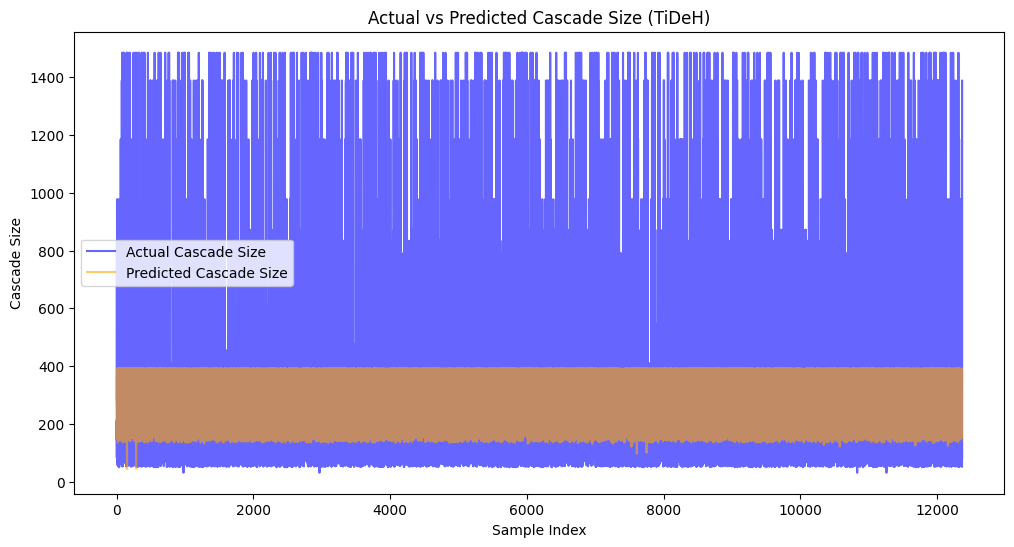

In [ ]:
# Step 10: Plotting actual vs. predicted values for cascade size
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cascade Size', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Cascade Size', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Cascade Size (TiDeH)')
plt.xlabel('Sample Index')
plt.ylabel('Cascade Size')
plt.legend()
plt.show()